In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau, pointbiserialr, chi2_contingency
import numpy as np
import networkx as nx

data_distr = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv")

dtDistrib = data_distr.dropna()

num_cols = dtDistrib.select_dtypes(include=[float, int])

corr_matrix = num_cols.corr()

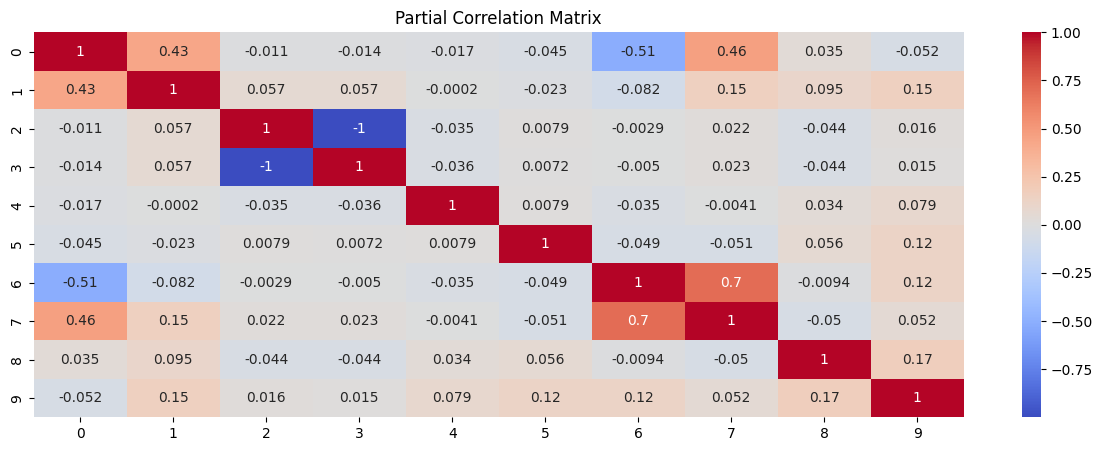

In [7]:
def partial_correlation(X):

    X = np.asarray(X)
    p = X.shape[1]
    P_corr = np.zeros((p, p), dtype = float)
    for i in range(p):
        for j in range(p):
            idx = np.ones(p, dtype = np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = np.linalg.lstsq(X[:, idx], X[:, i], rcond=None)[0]
            beta_j = np.linalg.lstsq(X[:, idx], X[:, j], rcond=None)[0]
            res_i = X[:, i] - X[:, idx].dot(beta_i)
            res_j = X[:, j] - X[:, idx].dot(beta_j)
            P_corr[i, j] = np.corrcoef(res_i, res_j)[0, 1]
    
    return P_corr


partial_corr_matrix = partial_correlation(num_cols)
plt.figure(figsize=(15, 5))
sns.heatmap(partial_corr_matrix, annot = True, cmap = 'coolwarm')
plt.title('Partial Correlation Matrix')
plt.show()

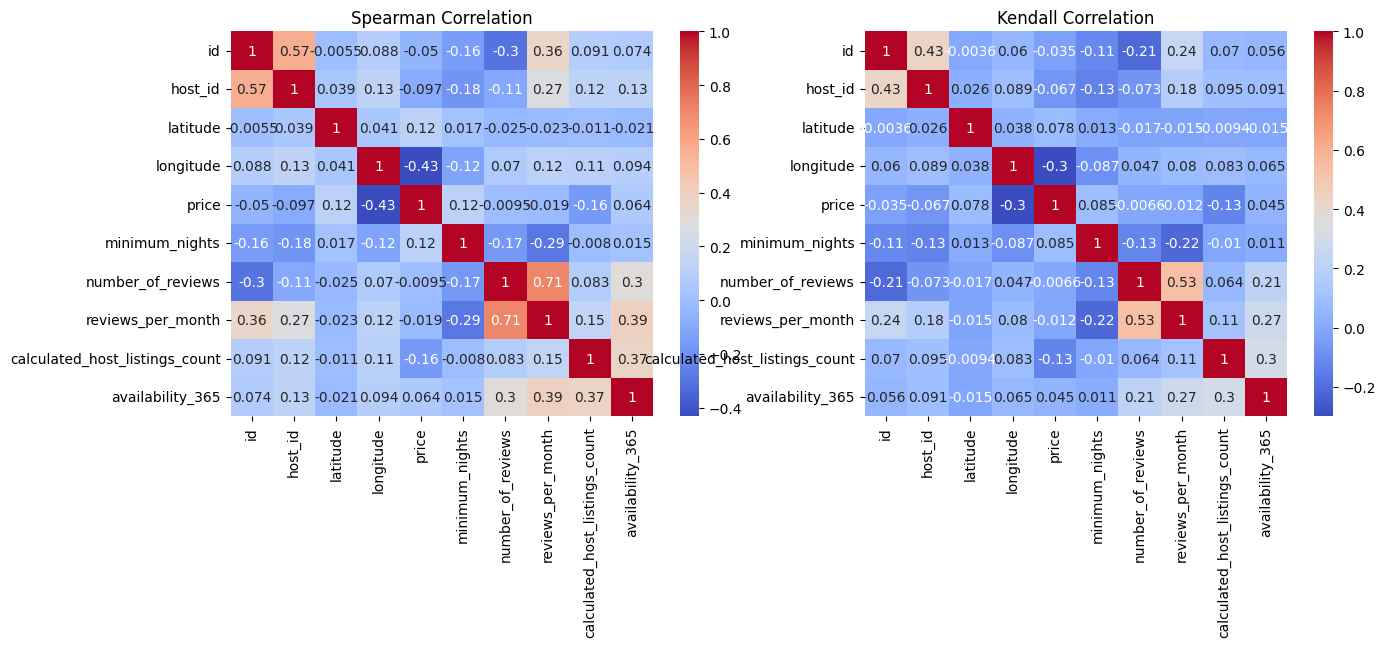

In [8]:
spearman_corr = num_cols.corr(method='spearman')
kendall_corr = num_cols.corr(method='kendall')

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.heatmap(spearman_corr, annot = True, cmap='coolwarm')
plt.title("Spearman Correlation")

plt.subplot(1, 2, 2)
sns.heatmap(kendall_corr, annot = True, cmap='coolwarm')
plt.title("Kendall Correlation")

plt.show()

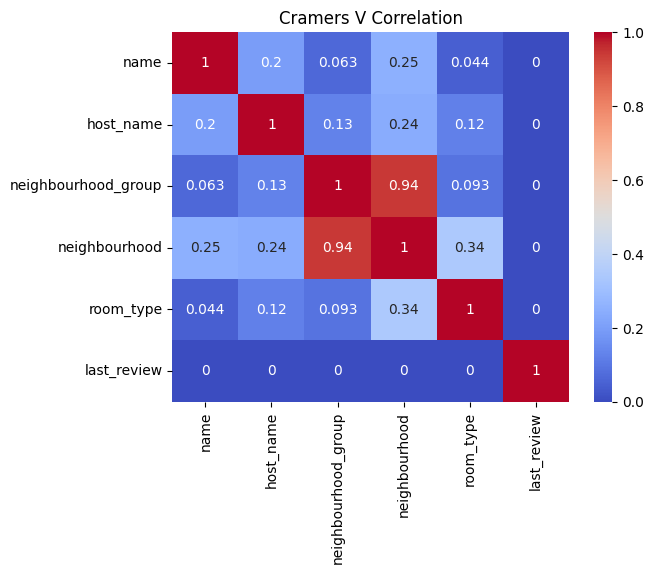

In [9]:
data_sampled = dtDistrib.sample(n=1000, random_state=42)

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/ (n-1))
    rcorr = r- ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)

    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cat_cols = data_sampled.select_dtypes(include=[object]).columns
cramers_v_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramers_v_matrix.loc[col1, col2] = cramers_v(data_sampled[col1], data_sampled[col2])


sns.heatmap(cramers_v_matrix.astype(float), annot = True, cmap='coolwarm')
plt.title("Cramers V Correlation")
plt.show()

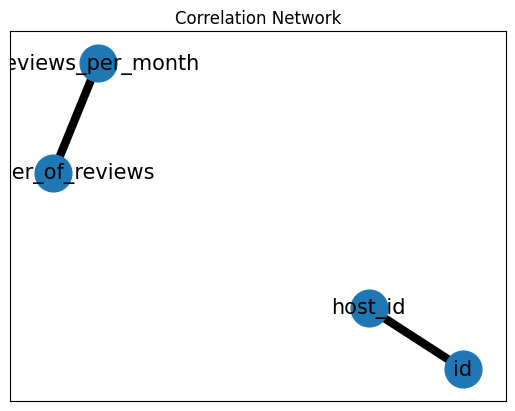

In [15]:
import networkx as nx

G = nx.Graph()
edges = [(u, v, {'weight': corr_matrix.at[u, v]}) for u in corr_matrix.columns for v in corr_matrix.columns if abs(corr_matrix.at[u, v]) > 0.5 and u != v]
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, width=6)
nx.draw_networkx_labels(G, pos, font_size=15)
plt.title("Correlation Network")
plt.show()